**Table of contents**<a id='toc0_'></a>    
- 1. [Preface               ](#toc1_)    
- 2. [Load datasets              ](#toc2_)    
  - 2.1. [Load earthquake catalog              ](#toc2_1_)    
  - 2.2. [Load PNSN tremor catalog (Wech)              ](#toc2_2_)    
- 3. [Intensity of triggering in the tremor region    ](#toc3_)    
  - 3.1. [In time ](#toc3_1_)    
  - 3.2. [In time   ](#toc3_2_)    
  - 3.3. [In space  ](#toc3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Preface                [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io
import xarray as xr

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

In [2]:
# Functions
def geo_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# 2. <a id='toc2_'></a>Load datasets               [&#128285;](#toc0_)

In [3]:
# Constants for everyone
day0 = np.datetime64('2009-08-01') 
volcanoes = {'Mt Hood': {'lat': 45.373, 'lon': -121.695},
             'Mt St Helens': {'lat': 46.191, 'lon': -122.194},
             'Mt Rainier': {'lat': 46.852, 'lon': -121.760}}

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog               [&#128285;](#toc0_)

In [10]:
# # Download usgs catalog
# # Format
# format_usgs = "format=csv"
# format_isc = "format=text"  # something that looks like csv

# # Date range
# t0 = "2009-08-01"
# t1 = "2024-04-04"
# date_range = f"starttime={t0}&endtime={t1}" 

# # Geographic range
# minlat = 39
# maxlat = 54
# minlon = -128
# maxlon = -121
# geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# # Magnitude range
# minmag = 1.6
# mag_range = f"minmagnitude={minmag}"

# # Event-type
# event_type = "eventtype=earthquake"

# url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# # url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
# print(url)
# stream = requests.get(url).content

# names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
# eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
# eq['date'] = pd.to_datetime(eq.time, format='%Y-%m-%dT%H:%M:%S.%fZ')
# eq = eq.sort_values('date')

In [11]:
# Get local catalog
path = workdir + 'projects/data/Catalogs/cascadia_eq_anss_0924/cascadia_eq_anss_0924.csv'

eq = pd.read_csv(path)
eq['date'] = pd.to_datetime(eq.time, format='%Y-%m-%dT%H:%M:%S.%fZ')
eq = eq.sort_values('date')

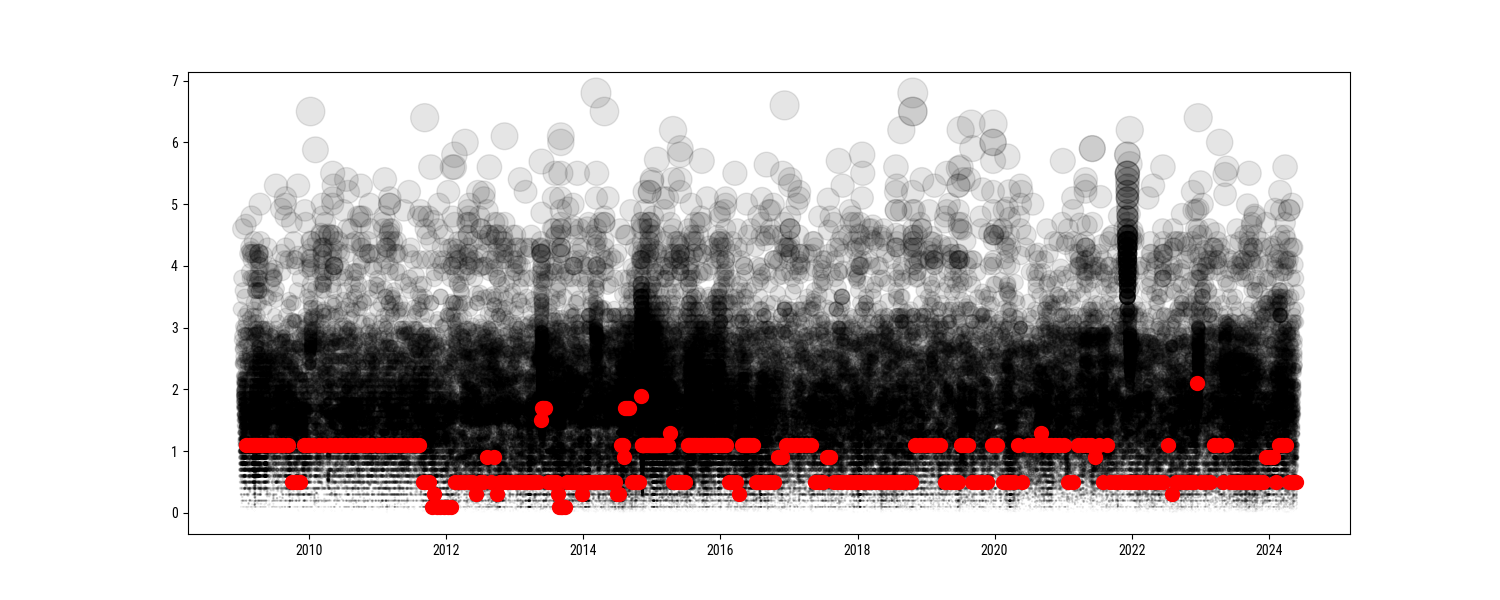

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(eq.date, eq.mag, s=10*eq.mag**2, c=[to_rgba('k', 0.1) for i in range(len(eq))])

N_eq = 0
dN_eq = 1000
N_eq_step = int(dN_eq / 3)
while N_eq < len(eq):
    h, bins = np.histogram(eq.mag.values[N_eq:N_eq+dN_eq+1], bins=np.arange(0, 7, 0.2))
    mc = bins[np.argmax(h)]+0.1
    ax.plot(np.mean(eq.date[N_eq:N_eq+dN_eq+1]), mc, 'ro', ms=10)
    N_eq += N_eq_step

plt.show()

## 2.2. <a id='toc2_2_'></a>Load PNSN tremor catalog (Wech)               [&#128285;](#toc0_)

In [37]:
# Load tremor
path = workdir + 'projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0524.csv'
names = ['lat', 'lon', 'depth', 'starttime', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)

tremor['date'] = pd.to_datetime(tremor['starttime'])
tremor = tremor.sort_values('date')
tremor = tremor.drop(columns=['starttime'])

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_27147/750222594.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


In [56]:
# Load slab model and project tremor to closest depth
path = workdir + "projects/data/Slabs/cascadia_slab_bostock23/cascadia_slab_bostock19.csv"
slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], delim_whitespace=True)

new_depths = np.zeros(len(tremor))
for i in range(len(new_depths)):
    dist = geo_distance(tremor.lat.iloc[i], tremor.lon.iloc[i], slab.lat, slab.lon)
    new_depths[i] = slab.depth.iloc[np.argmin(dist)]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_27147/2964862446.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], delim_whitespace=True)


In [57]:
tremor['new_depth'] = new_depths

In [39]:
# Load slab model and project tremor to closest depth
path = workdir + 'projects/data/Slabs/cascadia_slab_bloch23/grids_unmasked/t_depth.nc'

da = xr.open_dataarray(path)

# tremor['depth'] = np.nan
# for i, row in tremor.iterrows():
#     tremor.loc[i, 'depth'] = da.sel(lat=row['lat'], lon=row['lon'], method='nearest').values

# # Save it
# tremor.to_csv(workdir + 'projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0524_zmodel_bloch23.csv', columns=['date', 'lat', 'lon', 'depth', 'energy', 'duration'], index=False)

In [50]:
path = workdir + "projects/data/Slabs/cascadia_slab_bostock23/cascadia_slab_bostock19.csv"
slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], delim_whitespace=True)

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_27147/4060170780.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], delim_whitespace=True)


In [49]:
# Load tremor with depth model
path = workdir + 'projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0524_zmodel_bloch23.csv'
names = ['date', 'lat', 'lon', 'depth', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)

tremor['date'] = pd.to_datetime(tremor['date'])
tremor = tremor.sort_values('date')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_27147/586836326.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


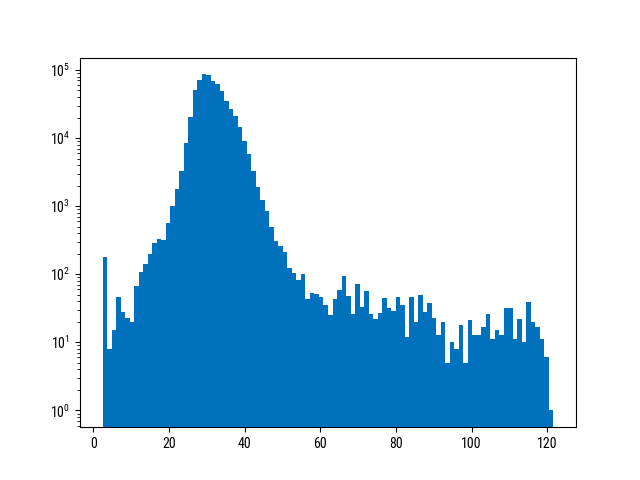

In [62]:
plt.figure()
plt.hist(tremor.new_depth, bins=100)
plt.yscale('log')
plt.show()

In [63]:
tremor

,date,lat,lon,depth,energy,duration,new_depth
0,2009-08-06 00:00:00,46.630000,-122.410000,43.44,0.000000,None,43.44
1,2009-08-06 00:12:30,45.490000,-122.750000,45.96,0.000000,None,45.96
2,2009-08-06 00:30:00,45.610000,-123.080000,35.65,0.000000,None,35.65
3,2009-08-06 00:57:30,45.720000,-122.490000,51.33,0.000000,None,51.33
4,2009-08-06 01:25:00,45.620000,-123.260000,30.77,0.000000,None,30.77
...,...,...,...,...,...,...,...
630909,2024-05-23 23:40:00,40.836856,-122.907459,NaN,78102.055554,300.0,28.64
630910,2024-05-23 23:42:30,40.821392,-123.029293,NaN,53854.028257,150.0,27.71
630911,2024-05-23 23:45:00,40.896519,-122.919157,NaN,26508.332483,150.0,28.36
630912,2024-05-23 23:47:30,40.839452,-122.723101,NaN,32064.604951,150.0,30.88


In [64]:
tremor.to_csv(workdir + 'projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0524_zmodel_bostock19.csv', columns=['date', 'lat', 'lon', 'depth', 'new_depth', 'energy', 'duration'], index=False)

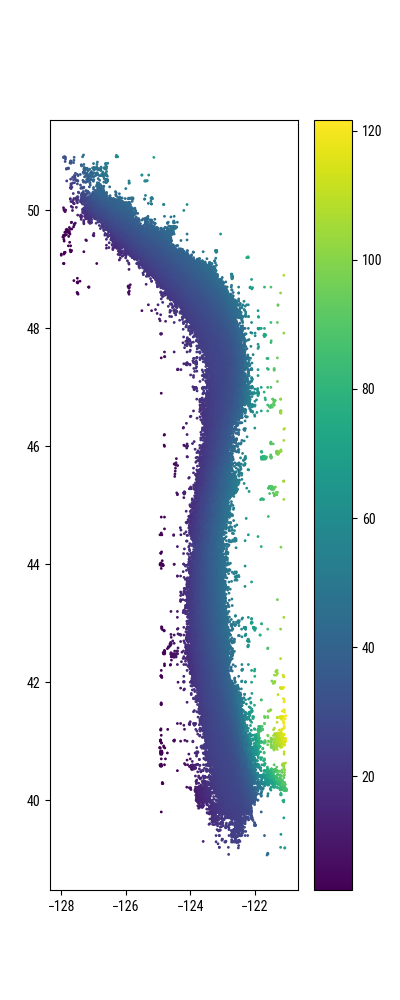

In [58]:
# Plot tremor
fig, ax = plt.subplots(figsize=(4, 10))
sc = ax.scatter(tremor.lon, tremor.lat, c=tremor.new_depth, s=1, cmap='viridis')
plt.colorbar(sc)

plt.show()

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_4976/1724284968.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tremor.lon, tremor.lat, c='.5', s=1, cmap='viridis')


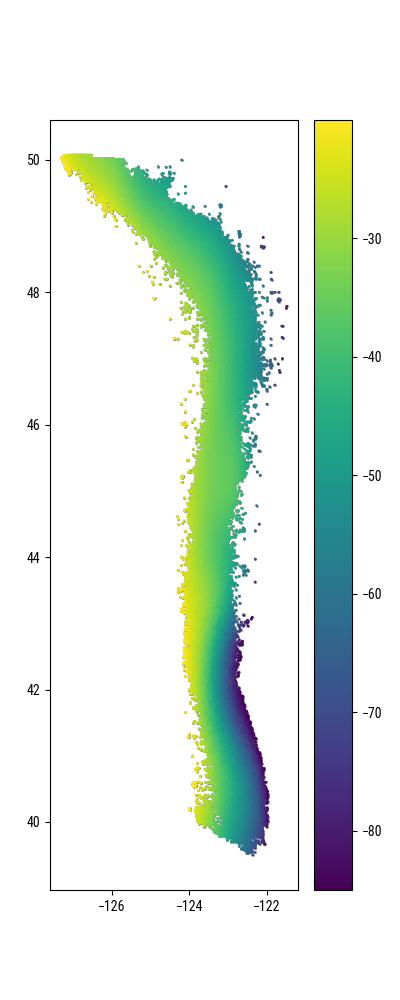

In [197]:
# Cut tremor to a given slab2 depth range (better slab model??)
tremor = tremor[(tremor.depth2 < -20) & (tremor.depth2 > -85)]

# Plot tremor
fig, ax = plt.subplots(figsize=(4, 10))
ax.scatter(tremor.lon, tremor.lat, c='.5', s=1, cmap='viridis')
sc = ax.scatter(tremor.lon[(tremor.depth2 < -20) & (tremor.depth2 > -85)], tremor.lat[(tremor.depth2 < -20) & (tremor.depth2 > -85)], c=tremor.depth2[(tremor.depth2 < -20) & (tremor.depth2 > -85)], s=1, cmap='viridis')
plt.colorbar(sc)
plt.show()

In [195]:
# Project onto a straight line
# --> Define center line of tremor
lat_center = np.arange(39, 52, 0.2)
dlat = 0.4
center_line = np.zeros((len(lat_center), 2))

for ii, lat in enumerate(lat_center):
    lat_min = lat - dlat
    lat_max = lat + dlat
    tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
    center_line[ii, 1] = (lat_min + lat_max) / 2
    center_line[ii, 0] = tremor_bin.lon.median()

# --> Fit it with a straight line to find the transect points
p = np.polyfit(center_line[~np.isnan(center_line[:, 0]), 1], center_line[~np.isnan(center_line[:, 0]), 0], 1)
N_point = p[0] * 52 + p[1]
S_point = p[0] * 39 + p[1]
transect_line = {'N':{'lat': 52, 'lon': N_point}, 'S': {'lat': 39, 'lon': S_point}}

# --> Project earthquakes onto the line
t = transect(eq.lon.values, eq.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]

# --> Project tremor onto the line
t = transect(tremor.lon.values, tremor.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
tremor['xf'] = t[0]
tremor['yf'] = t[1]

# --> Project volcanoes onto the line
for volcano in volcanoes.keys():
    t = transect(volcanoes[volcano]['lon'], volcanoes[volcano]['lat'], transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
    volcanoes[volcano]['xf'] = t[0]
    volcanoes[volcano]['yf'] = t[1]

# 3. <a id='toc3_'></a>Intensity of triggering in the tremor region     [&#128285;](#toc0_)


## 3.1. <a id='toc3_1_'></a>In time  [&#128285;](#toc0_)

In [142]:
# Select earthquakes and tremor to use for this analysis
date_range = [np.datetime64('2009-08-01'), np.datetime64('2024-01-01')]

eq_in_range = eq.copy()
eq_in_range = eq_in_range[(eq_in_range.date >= date_range[0]) & (eq_in_range.date <= date_range[1])]

tremor_in_range = tremor.copy()
tremor_in_range = tremor_in_range[(tremor_in_range.date >= date_range[0]) & (tremor_in_range.date <= date_range[1])]
set_depth = 35.  # in km, because locations are bad (you could also project locations onto the Slab2 surface)

In [166]:
# Spatially binned baseline rate of tremor that constitutes our background, to check variations against
dx = 2  # spatial spacing of the grid in km
dy = 2  # spatial spacing of the grid in km

x_bins = np.arange(tremor_in_range.xf.min()-dx/2, tremor_in_range.xf.max()+ 3*dx/2, dx)
y_bins = np.arange(tremor_in_range.yf.min()-dx/2, tremor_in_range.yf.max()+3*dy/2, dy)

# Compute the 2D histogram of tremor occurence
H, xedges, yedges = np.histogram2d(tremor_in_range.xf, tremor_in_range.yf, bins=(x_bins, y_bins))

# Make a dataframe cataloguing number of events, x,y center of the cell for all grid cells with tremor in them
x, y = np.meshgrid((xedges[1:] + xedges[:-1])/2, (yedges[1:] + yedges[:-1])/2)
x = x.T.flatten()
y = y.T.flatten()
z = np.ones_like(x) * set_depth
n_ev = H.flatten()
trm_grid = pd.DataFrame({'n_ev': n_ev, 'x': x, 'y': y, 'z': z})

# Remove grid cells with too few tremor events
trm_grid = trm_grid[trm_grid.n_ev > 0]
print('Number of grid cells with tremor: {:d}'.format(len(trm_grid)))

# # Plot
# fig, ax = plt.subplots(1, 1, figsize=(6, 2))

# # Plot the earthquakes
# ax.scatter(tremor_in_range.xf, -tremor_in_range.yf, s=5, c='C1', alpha=0.1)
# ax.scatter(trm_grid.x, -trm_grid.y, s=trm_grid.n_ev/2, c='C0', alpha=0.5)

# plt.tight_layout()
# plt.show()


Number of grid cells with tremor: 33106


## 3.2. <a id='toc3_2_'></a>In time    [&#128285;](#toc0_)

In [167]:
# Parameters
time_bins = np.array([-96, -48, -24, -12, -6, -3, -1, 0, 1, 3, 6, 12, 24, 48, 96]) # in hours
# time_bins = np.arange(-100, 110, 10)  # in hours

dmin = 0
dmax = 20
epicentral = True

# Select which earthquakes to use for triggering analysis
mag_min = 2.
mag_max = 6.
eq_sample = eq_in_range[(eq_in_range.mag >= mag_min) & (eq_in_range.mag <= mag_max)]

print('Number of earthquakes in the sample: {:d}'.format(len(eq_sample)))

Number of earthquakes in the sample: 10076


In [168]:
# Compute the baseline rate of tremor around the selected earthquakes
n_trm_base_count = np.zeros(len(eq_sample))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the earthquake location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]
    
    # Compute the distance between the earthquake and all grid cells with tremor in them
    distances_trm = np.sqrt((trm_grid.x - eq_x)**2 + (trm_grid.y - eq_y)**2 + (trm_grid.z - eq_z)**2)
    
    # Select grid cells that are within the distance range
    trm_grid_sample = trm_grid[(distances_trm >= dmin) & (distances_trm <= dmax)]
    
    # Count the number of binned tremor detections in each time bin
    n_trm_base_count[ii] = np.sum(trm_grid_sample.n_ev)

# Compute count for each cluster and time bin
n_trm_base = np.zeros((len(time_bins)-1, len(eq_sample)))

for it in range(len(time_bins)-1):
    n_trm_base[it, :] = n_trm_base_count / ((date_range[1] - date_range[0])/np.timedelta64(1, 'h')) * (time_bins[it+1] - time_bins[it])

# Remove the earthquakes that have no tremor around them (because too far from tremor)
eq_sample = eq_sample[n_trm_base_count != 0]
n_trm_base = n_trm_base[:, n_trm_base_count != 0]
print('\nNumber of earthquakes in the sample with tremor around them: {:d}'.format(len(eq_sample)))

Processing earthquake 10076/10076...
Number of earthquakes in the sample with tremor around them: 2973


In [169]:
# Count the number of tremor detections around trigger earthquakes
n_trm = np.zeros((len(time_bins)-1, len(eq_sample)))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the trigger earthquake location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]

    # Only consider tremor detections close to the earthquake, in time
    tremor_sample = tremor_in_range[(tremor_in_range.date >= eq_sample.date[eq_id] - np.timedelta64(time_bins[-1], 'h')) & (tremor_in_range.date <= eq_sample.date[eq_id] + np.timedelta64(time_bins[-1], 'h'))]
    
    # Compute the distance between the earthquake and all tremor detections close in time
    distance_to_tremor = np.sqrt((tremor_sample.xf - eq_x)**2 + (tremor_sample.yf - eq_y)**2 + (set_depth - eq_z)**2)
    
    # Select tremor that are within the distance range
    tremor_sample = tremor_sample[(distance_to_tremor >= dmin) & (distance_to_tremor <= dmax)]
    
    # Compute the time difference between the trigger earthquake and the selected tremor detections
    time_diff_trm = (tremor_sample.date - eq_sample.date[eq_id]).dt.total_seconds() / 3600  # in hours
    
    # Count the number of tremor detection in each time bin
    n_trm[:, ii], _ = np.histogram(time_diff_trm, bins=time_bins)

In [170]:
# Bootstrap (shuffling earthquakes)
n_iter = 10

n_trm_boot = np.zeros((len(time_bins)-1, len(eq_sample), n_iter))
eq_sample_uniform = eq_sample.copy()

t0 = time.time()
for iboot in range(n_iter):
    print('Bootstrapping {:d}/{:d}...'.format(iboot+1, n_iter), end='\r')

    # Resample earthquake occurence times, from uniform distribution, between the first and last earthquake
    seconds_from_start = np.random.uniform(0, (date_range[1] - date_range[0]) / np.timedelta64(1, 's'), len(eq_sample_uniform))
    eq_sample_uniform.date = date_range[0] + pd.to_timedelta(seconds_from_start, unit='s')

    # Count tremor around resampled earthquakes
    for ii, eq_id in enumerate(eq_sample_uniform.index):
        # Get the earthquake location
        eq_x = eq_sample_uniform.xf[eq_id]
        eq_y = eq_sample_uniform.yf[eq_id]
        eq_z = eq_sample_uniform.depth[eq_id]

        # Only consider tremor detections close to the earthquake in time
        tremor_sample = tremor_in_range[(tremor_in_range.date >= eq_sample_uniform.date[eq_id] - np.timedelta64(time_bins[-1], 'h')) & (tremor_in_range.date <= eq_sample_uniform.date[eq_id] + np.timedelta64(time_bins[-1], 'h'))]

        # Compute the distance between the earthquake and all tremor detections close in time
        if epicentral:
            distance_to_tremor = np.sqrt((tremor_sample.xf - eq_x)**2 + (tremor_sample.yf - eq_y)**2)
        else:
            distance_to_tremor = np.sqrt((tremor_sample.xf - eq_x)**2 + (tremor_sample.yf - eq_y)**2 + (tremor_sample.depth - eq_z)**2)

        # Select tremor detections that are within the distance range to the trigger earthquake
        tremor_sample = tremor_sample[(distance_to_tremor >= dmin) & (distance_to_tremor <= dmax)]

        # Compute the time difference between the earthquake and the tremor detection
        time_diff_tremor = (tremor_sample.date - eq_sample_uniform.date[eq_id]).dt.total_seconds() / 3600  # in hours

        # Count the number of tremor detection in each time bin
        n_trm_boot[:, ii, iboot], _ = np.histogram(time_diff_tremor, bins=time_bins)
print('{:} bootstrap iterations took {:.1f} seconds'.format(n_iter, time.time() - t0))

10 bootstrap iterations took 49.4 seconds


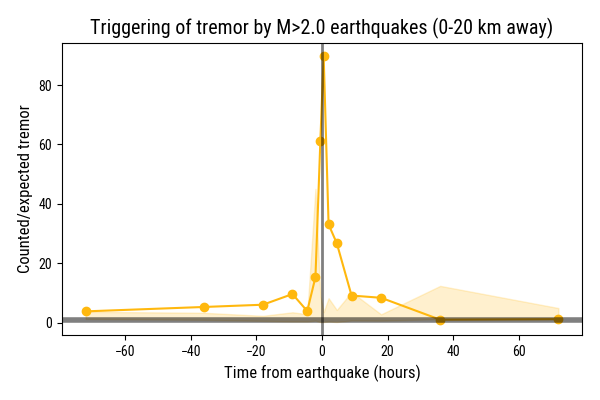

In [171]:
# Results
trm_ratio = n_trm / n_trm_base
trm_mean_ratio = np.mean(trm_ratio, axis=1)

trm_ratio_boot = np.zeros((len(time_bins)-1, n_iter))
for iboot in range(n_iter):
    trm_ratio_boot[:, iboot] = np.mean(n_trm_boot[:, :, iboot] / n_trm_base, axis=1)

q = 20
ci_up = np.percentile(trm_ratio_boot, 100 - q/2, axis=1)
ci_lo = np.percentile(trm_ratio_boot, q/10, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Time from earthquake (hours)')
ax.set_ylabel('Counted/expected tremor')
ax.set_title('Triggering of tremor by M>{:.1f} earthquakes ({:.0f}-{:.0f} km away)'.format(mag_min, dmin, dmax))

ax.plot((time_bins[1:] + time_bins[:-1]) / 2, trm_mean_ratio, 'o-', c='C2')
ax.axhline(1, c=to_rgba('k', .5), lw=4)
ax.axvline(0, lw=2, c=to_rgba('k', .5))
ax.fill_between((time_bins[1:] + time_bins[:-1]) / 2, ci_lo, ci_up, color=to_rgba('C2', .2), zorder=1, label='{:d}%-{:d}% CI'.format(int(q/2), int(100-q/2)))

plt.tight_layout()
plt.show()

Number of earthquakes with signal: 163


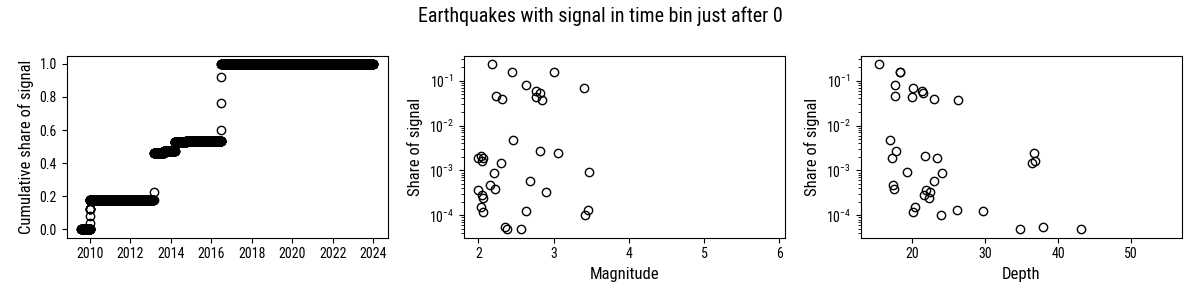

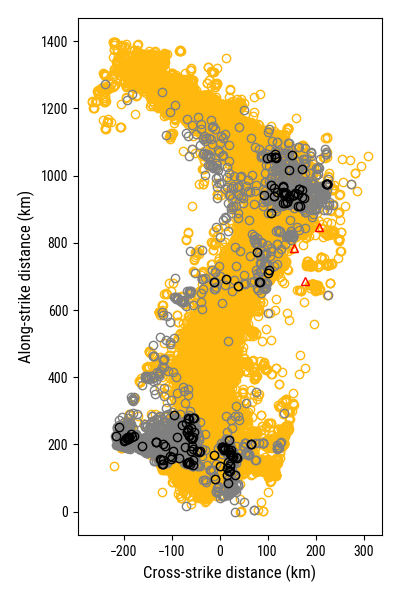

In [172]:
# What earthquakes are responsible for this signal?
# --> In time bin just after 0
ii = np.where(time_bins == 0)[0][0]

with_signal = np.sum(trm_ratio[ii:, :], axis=0) > 1
print('Number of earthquakes with signal: {:d}'.format(np.sum(with_signal)))

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Earthquakes with signal in time bin just after 0')
ax = axes[0]
ax.set_ylabel('Cumulative share of signal')
ax.plot(eq_sample.date, np.cumsum(trm_ratio[ii, :] / len(eq_sample) / trm_mean_ratio[ii]), 'o', mec='k', mfc=[0,0,0,0])

ax = axes[1]
ax.set_ylabel('Share of signal')
ax.set_xlabel('Magnitude')
ax.semilogy(eq_sample.mag, trm_ratio[ii, :] / trm_mean_ratio[ii] / len(eq_sample), 'o', mec='k', mfc=[0,0,0,0])

ax = axes[2]
ax.set_ylabel('Share of signal')
ax.set_xlabel('Depth')
ax.semilogy(eq_sample.depth, trm_ratio[ii, :] / trm_mean_ratio[ii] / len(eq_sample), 'o', mec='k', mfc=[0,0,0,0])

plt.tight_layout()
plt.show()

# --> In space
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
ax.set_ylabel('Along-strike distance (km)')
ax.set_xlabel('Cross-strike distance (km)')

ax.plot(-tremor_in_range.yf, tremor_in_range.xf, 'o', mec='C2', mfc=[0,0,0,0], zorder=0)
ax.plot(-eq_sample.yf, eq_sample.xf, 'o', mec='.5', mfc=[0,0,0,0], zorder=1)
for v in volcanoes.values():
    ax.plot(-v['yf'], v['xf'], '^', mec='r', mfc=[0,0,0,0], zorder=2)
ax.plot(-eq_sample[with_signal].yf, eq_sample[with_signal].xf, 'o', mec='k', mfc=[0,0,0,0], zorder=1)

plt.tight_layout()
plt.show()

## 3.3. <a id='toc3_3_'></a>In space   [&#128285;](#toc0_)

In [138]:
# Parameters
dist_bins = np.arange(0, 200, 10) # in km
# time_bins = np.arange(-100, 110, 10)  # in hours

tmin = 0
tmax = 20

# Select which earthquakes to use for triggering analysis
mag_min = 2.
eq_sample = eq_in_range[eq_in_range.mag >= mag_min]

print('Number of earthquakes in the sample: {:d}'.format(len(eq_sample)))

Number of earthquakes in the sample: 10085


In [111]:
# # Distance of this earthquake to all lfes and all earthquakes
# def compute_distance(x1, y1, z1, x2, y2, z2, epicentral=True):
#     if epicentral:
#         return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
#     else:
#         return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
                       
# all_trm_eq_dist = compute_distance(eq_sample.xf.values[np.newaxis, :],
#                                    eq_sample.yf.values[np.newaxis, :],
#                                    eq_sample.depth.values[np.newaxis, :],
#                                    trm_grid.x.values[:, np.newaxis],
#                                    trm_grid.y.values[:, np.newaxis],
#                                    trm_grid.z.values[:, np.newaxis])

# weights_trm = np.repeat(trm_grid.n_ev.values, len(eq_sample))

# fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_title('Distances of the sample earthquakes to all tremor locations')
# ax.set_xlabel('Distance from sample earthquake')
# ax.set_ylabel('Number of tremor detections')
# ax.hist(all_trm_eq_dist.flatten(), bins=dist_bins, weights=weights_trm, fc='C2')

# plt.tight_layout()
# plt.show()

In [139]:
# Count the EXPECTED number of tremor detections around trigger earthquakes
epicentral = True

n_trm_base_count = np.zeros((len(dist_bins)-1, len(eq_sample)))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the earthquake location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]

    # Compute the distance between the earthquake and all tremor close in time
    if epicentral:
        distances_trm_grid = np.sqrt((trm_grid.x - eq_x)**2 + (trm_grid.y - eq_y)**2)
    else:
        distances_trm_grid = np.sqrt((trm_grid.x - eq_x)**2 + (trm_grid.y - eq_y)**2 + (trm_grid.z - eq_z)**2)
    
    # Count the number of tremor in each time bin
    n_trm_base_count[:, ii] = np.histogram(distances_trm_grid, bins=dist_bins, weights=trm_grid.n_ev)[0] / ((date_range[1] - date_range[0])/np.timedelta64(1, 'h')) * (tmax - tmin)

# Remove events that are too far from tremor (outside of distance range)
eq_sample = eq_sample[np.sum(n_trm_base_count, axis=0) != 0]
n_trm_base_count = n_trm_base_count[:, np.sum(n_trm_base_count, axis=0) != 0]
print('\nNumber of earthquakes in the sample with tremor around them: {:d}'.format(len(eq_sample)))

Processing earthquake 10085/10085...
Number of earthquakes in the sample with tremor around them: 8970


In [140]:
# Count the number of tremor detections around trigger earthquakes
n_trm = np.zeros((len(dist_bins)-1, len(eq_sample)))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the earthquake location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]

    # Only consider tremor close to the eurthqake in time
    trm_sample = tremor_in_range[(tremor_in_range.date >= eq_sample.date[eq_id] - np.timedelta64(tmin, 'h')) & (tremor_in_range.date <= eq_sample.date[eq_id] + np.timedelta64(tmax, 'h'))]
    
    # Compute the distance between the earthquake and all tremor close in time
    if epicentral:
        distances_trm = np.sqrt((trm_sample.xf - eq_x)**2 + (trm_sample.yf - eq_y)**2)
    else:
        distances_trm = np.sqrt((trm_sample.xf - eq_x)**2 + (trm_sample.yf - eq_y)**2 + (set_depth - eq_z)**2)
    
    # Count the number of tremor in each time bin
    n_trm[:, ii], _ = np.histogram(distances_trm, bins=dist_bins)


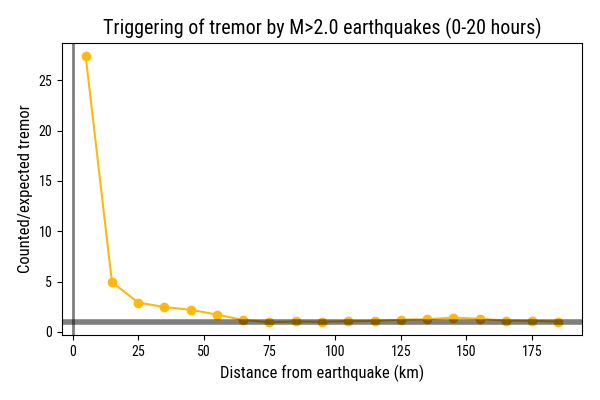

In [141]:
# Results
trm_mean_ratio = np.mean(n_trm, axis=1) / np.mean(n_trm_base_count, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Distance from earthquake (km)')
ax.set_ylabel('Counted/expected tremor')
ax.set_title('Triggering of tremor by M>{:.1f} earthquakes ({:.0f}-{:.0f} hours)'.format(mag_min, tmin, tmax))

ax.plot((dist_bins[1:] + dist_bins[:-1]) / 2, trm_mean_ratio, 'o-', c='C2')
ax.axhline(1, c=to_rgba('k', .5), lw=4)
ax.axvline(0, lw=2, c=to_rgba('k', .5))

plt.tight_layout()
plt.show()
